### Your very own neural network

In this notebook we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

<img src="frankenstein.png" style="width:20%">

In [1]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

Here goes our main class: a layer that can do .forward() and .backward() passes.

In [34]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [35]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        zeros=np.zeros(np.shape(input))
        return np.maximum(zeros,input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [36]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [158]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        f=np.dot(np.transpose(self.weights),np.transpose(input))
        f_x=np.add(np.transpose(f),np.transpose(self.biases))
        return (f_x)
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        
        grad_input=np.dot((grad_output),np.transpose(self.weights))
        grad_weights = np.dot(input.T,grad_output)#<your code here>
        grad_biases = np.sum(grad_output,axis=0)#<your code here>

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input



### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [160]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [161]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [162]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )

numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )



grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [163]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [164]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

Using TensorFlow backend.


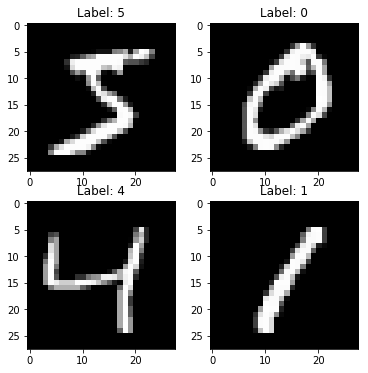

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [169]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

print(len(network))

5


In [194]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    # <your code here>
    for i in range network:
        l=i.forward(input)
        activations.append(l)
        input=l
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    dz=loss_grad
    # <your code: propagate gradients through the network>
    for ind in reversed(range(len(network))):
        c_layer= network[i]
        c_in=layer_inputs[i]
        dz=c_layer.backward(c_in,dz)
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [180]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [181]:
from IPython.display import clear_output
train_log = []
val_log = []

In [195]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

A Jupyter Widget

loss_grad [[-0.02812781  0.00313313  0.00312421  0.00312336  0.0031261   0.0031234
   0.00312007  0.00313243  0.00312145  0.00312367]
 [ 0.00311928 -0.02812529  0.00312346  0.00313041  0.00312446  0.00312622
   0.00312532  0.00312061  0.00312941  0.00312612]
 [ 0.00312031  0.00312708  0.00312616  0.00312875  0.00312427  0.00313077
   0.00312339  0.00312659  0.00311909 -0.02812642]
 [ 0.00312186  0.00313033  0.00312397  0.00313037  0.00312673  0.00313005
   0.00311204  0.00312413  0.0031239  -0.02812338]
 [ 0.00312454  0.00312241 -0.02812436  0.00312537  0.00312438  0.00312918
   0.00312041  0.0031274   0.0031268   0.00312386]
 [ 0.0031218   0.0031247   0.00312898  0.00312162  0.00312465  0.00312664
   0.00312107 -0.02812032  0.00312407  0.00312679]
 [ 0.00312231  0.00312159  0.00312811  0.00312766  0.00312779  0.00312221
  -0.02813216  0.00313044  0.00312443  0.00312763]
 [ 0.00312443  0.0031233   0.00312385  0.00312495 -0.02812521  0.00312389
   0.00312316  0.00312938  0.00312954  0.0

loss_grad [[ 0.00312654  0.00312254  0.00312802  0.00312202  0.00312599  0.00312401
   0.00312269  0.00313139  0.0031255  -0.0281287 ]
 [ 0.00312249  0.00312946  0.00312753  0.00313064 -0.02812659  0.00312693
   0.00312046  0.00312253  0.00312259  0.00312398]
 [ 0.00312481  0.00313087  0.00312272  0.00312202  0.00312677  0.00312739
  -0.02812967  0.00312247  0.0031265   0.00312612]
 [ 0.00312386  0.00312214 -0.0281268   0.00312444  0.00312822  0.00312694
   0.00312698  0.00312563  0.00312582  0.00312276]
 [ 0.00311717  0.00312412  0.00312955  0.00312849 -0.02812655  0.00312595
   0.00312132  0.00312533  0.00312445  0.00313015]
 [ 0.00312163  0.00312275  0.00312486  0.00313056  0.00312478  0.00312628
   0.00312801 -0.02812587  0.00312354  0.00312346]
 [ 0.00312442  0.00312341  0.00312451  0.00312503  0.00312638  0.00312747
   0.00311843  0.00312633 -0.02812032  0.00312434]
 [ 0.00312252  0.00312516  0.00312441  0.003123    0.00312319  0.00312763
   0.00312383 -0.02811886  0.00312577  0.

loss_grad [[-0.02812256  0.00312836  0.00312511  0.00312551  0.00312716  0.00311942
   0.00311986  0.00313064  0.00312354  0.00312297]
 [ 0.0031177   0.00313495  0.00312275 -0.02812444  0.00312298  0.00313311
   0.00312081  0.00312085  0.00312306  0.00312822]
 [-0.02812639  0.00312855  0.00312467  0.0031275   0.00312425  0.00312262
   0.00311841  0.003132    0.00312557  0.00312281]
 [ 0.00311966  0.00313189  0.00312634  0.00312476  0.00312231 -0.0281238
   0.00312538  0.00312806  0.00312437  0.00312104]
 [-0.02812869  0.00312945  0.00312311  0.003131    0.00312215  0.00311765
   0.00312264  0.00313051  0.00312615  0.00312602]
 [ 0.00311888 -0.02812491  0.00312938  0.00313033  0.00312582  0.0031257
   0.00312524  0.00312351  0.00312088  0.00312518]
 [ 0.00312353  0.0031286  -0.0281242   0.00312231  0.00312914  0.003123
   0.00312062  0.00313     0.00312522  0.00312178]
 [ 0.00312637  0.00312834 -0.02812288  0.00312595  0.00312866  0.00311978
   0.00312196  0.00313158  0.00312253  0.0031

loss_grad [[ 0.00312262  0.00313016  0.00312411  0.00312908  0.0031228   0.00312194
   0.00311691 -0.02812493  0.0031272   0.0031301 ]
 [ 0.00311856  0.00313458  0.00312442  0.00312629  0.00312506 -0.02812222
   0.00312381  0.00312613  0.00312217  0.00312121]
 [ 0.00312183 -0.02812704  0.00312816  0.00312552  0.00312635  0.00312553
   0.00312296  0.00312547  0.00312437  0.00312684]
 [-0.02813111  0.00313143  0.00313079  0.00312952  0.00312304  0.00312027
   0.00312281  0.00313249  0.00311791  0.00312286]
 [ 0.0031182   0.00312425  0.00312671  0.00312691  0.00312507  0.00312586
   0.00312414  0.00312867  0.00312494 -0.02812475]
 [ 0.00312263  0.00312763  0.00312542  0.00312984  0.00312576  0.00312495
   0.00312615 -0.02812149  0.00311729  0.00312183]
 [ 0.00312236  0.00312659  0.00312401  0.00312826  0.00312412  0.00312471
  -0.02812714  0.00312801  0.00312318  0.00312592]
 [ 0.00312023 -0.02812342  0.00312663  0.00312897  0.0031261   0.00312253
   0.00312276  0.00313058  0.00312231  0.

loss_grad [[ 0.00311984  0.00312433  0.00312762  0.00312946  0.00312085  0.00312482
   0.00312457  0.00312898  0.00312594 -0.02812642]
 [ 0.00312761  0.00312857  0.00312713  0.00312805  0.00312574 -0.02812594
   0.00311853  0.0031237   0.00312452  0.0031221 ]
 [ 0.00312179  0.00312143  0.00312638  0.00312568  0.00312745  0.00312575
  -0.02812704  0.003126    0.00312462  0.00312793]
 [ 0.00311497  0.00312779  0.00312682  0.00313207 -0.028129    0.00312405
   0.00311781  0.00312665  0.00313067  0.00312816]
 [ 0.00312164  0.00312394  0.00312819  0.00313096  0.00312541  0.00312299
  -0.02812801  0.00312698  0.0031255   0.0031224 ]
 [ 0.00312225  0.00312416  0.003128    0.00313043  0.00312452  0.00312181
  -0.02812634  0.00312928  0.00312543  0.00312047]
 [ 0.0031189   0.00312813  0.00312674 -0.0281291   0.00312752  0.00312594
   0.0031249   0.00312758  0.00312279  0.00312661]
 [-0.02812613  0.00312155  0.00312614  0.00313376  0.00312796  0.00312785
   0.00312176  0.0031276   0.00311565  0.

loss_grad [[-0.02812518  0.00312558  0.00312385  0.00313069  0.00313059  0.00312479
   0.00312336  0.00312927  0.00311577  0.00312129]
 [ 0.00312054  0.00311978  0.00312471  0.00313006  0.00312142  0.0031261
   0.00312665 -0.02812102  0.00312719  0.00312456]
 [ 0.00311836  0.00313336  0.00312702  0.00312567  0.00312556 -0.02812405
   0.003121    0.00312672  0.00312341  0.00312294]
 [ 0.00312104 -0.02812517  0.00312936  0.00312917  0.00312504  0.0031263
   0.00312314  0.00312553  0.00312151  0.0031241 ]
 [ 0.00312251  0.00312497  0.00312996  0.00312824  0.00311929  0.00312819
   0.00312232 -0.02812452  0.00312432  0.00312473]
 [ 0.00311929  0.0031239   0.00312836  0.0031319   0.00312064  0.0031245
   0.00312012  0.00312597 -0.02811974  0.00312505]
 [ 0.0031232   0.00312464  0.00313026  0.00312934  0.00312021  0.00312013
   0.00312187  0.00312972 -0.02812296  0.00312359]
 [ 0.00312237  0.00312433  0.00312797  0.00312587  0.00312207 -0.02812565
   0.00312116  0.00312902  0.00312924  0.003

loss_grad [[ 0.00312213  0.00313215  0.00312413 -0.02812332  0.00312897  0.003123
   0.00312126  0.00312644  0.00312244  0.0031228 ]
 [ 0.00312486  0.00312293  0.00312842  0.00312685  0.00312749  0.00312619
   0.00312206 -0.02812264  0.00312091  0.00312292]
 [ 0.00311818  0.00312486  0.00312861 -0.02812114  0.00312127  0.00312329
   0.00312212  0.00313005  0.00312632  0.00312643]
 [ 0.00312466  0.00312698  0.00312715  0.00312406  0.00312875  0.00312162
  -0.02813521  0.00312995  0.00312555  0.00312648]
 [ 0.00312132 -0.02812623  0.0031266   0.00312637  0.00312124  0.00312709
   0.00312513  0.00312173  0.00312951  0.00312724]
 [ 0.00312379  0.00312324  0.0031244   0.00312872  0.00312594  0.00312521
   0.00311889  0.00312707  0.00312821 -0.02812546]
 [ 0.00311863 -0.02812584  0.00312746  0.00313029  0.00312671  0.00312462
   0.00312403  0.00312398  0.00312522  0.00312488]
 [ 0.0031266   0.00312489  0.00312697  0.00312402  0.00312315  0.00312444
  -0.02813013  0.00312986  0.0031234   0.00

loss_grad [[ 0.00312013  0.00312334  0.00313053  0.00312689  0.00311922  0.00312242
   0.00311719  0.00313112  0.00313203 -0.02812288]
 [-0.02812897  0.00312586  0.00312636  0.00312952  0.00312233  0.00311941
   0.0031229   0.00312945  0.00312945  0.0031237 ]
 [ 0.00312424  0.00313025  0.00312766  0.00313105  0.00312311  0.00312541
   0.00311753  0.00312238 -0.02812534  0.0031237 ]
 [ 0.0031194   0.00312498  0.0031233   0.00312931  0.00312441 -0.02812316
   0.00312373  0.00312537  0.00312757  0.0031251 ]
 [ 0.00312441  0.00312535  0.00312414  0.00312365  0.00312449  0.00312389
  -0.028128    0.00312662  0.00312765  0.0031278 ]
 [ 0.00312575  0.00312347  0.00312363  0.00312467  0.00312594  0.00312457
  -0.02812938  0.00313205  0.0031235   0.0031258 ]
 [ 0.00311776  0.00312351  0.00313052  0.00313263  0.00312455  0.00312376
  -0.02812654  0.00312621  0.00312558  0.00312201]
 [ 0.00312278  0.00312353  0.00312817  0.00313036  0.00312433  0.00312301
   0.00312111  0.00312931 -0.02812403  0.

loss_grad [[-0.02812777  0.0031271   0.0031235   0.0031257   0.0031259   0.00312713
   0.00311967  0.00312901  0.00312284  0.00312693]
 [ 0.00312114  0.00312029 -0.02812446  0.00313312  0.00312433  0.00312688
   0.00312586  0.00312358  0.00312634  0.00312291]
 [ 0.00312296  0.00312481  0.00312636  0.00312479  0.00312863  0.00312268
  -0.02813229  0.00313179  0.00312267  0.0031276 ]
 [ 0.00312519  0.00312413  0.00312503  0.00312505 -0.02812631  0.00312372
   0.00311948  0.00312835  0.00312983  0.00312553]
 [ 0.00312229  0.00312896  0.00312108  0.00312716  0.00312834 -0.02812544
   0.00312516  0.0031282   0.00312159  0.00312266]
 [ 0.00312071  0.00312774 -0.02812087  0.00312991  0.00312616  0.00312079
   0.00311858  0.00313018  0.0031225   0.0031243 ]
 [ 0.00312435  0.00312503  0.00312829  0.00313108  0.00312468 -0.02813257
   0.00312377  0.00312773  0.00312544  0.00312219]
 [-0.02812675  0.00312552  0.00312498  0.00313023  0.00312163  0.00311952
   0.00312071  0.00313165  0.00312536  0.

loss_grad [[ 0.0031176   0.00312429  0.00312517  0.00313424  0.00312319  0.00312041
  -0.02812589  0.00312486  0.00313017  0.00312596]
 [ 0.00312233  0.00312172  0.00312722  0.00312787  0.00312157  0.00312157
   0.00312696 -0.02812047  0.0031263   0.00312492]
 [ 0.00312041  0.00312107  0.00312224  0.00313064  0.00312479  0.00312576
   0.00312726 -0.02812475  0.00312743  0.00312514]
 [ 0.0031212   0.00313041  0.00312295 -0.02812373  0.00313133  0.00312593
   0.00312179  0.00312851  0.00311816  0.00312345]
 [ 0.00312125 -0.0281283   0.00312894  0.00312592  0.00312591  0.00312665
   0.00312213  0.00313012  0.00312356  0.00312381]
 [ 0.00312226  0.00312402  0.00312972  0.00312356  0.00312534  0.00312653
   0.00312353  0.00312409 -0.02812494  0.00312588]
 [ 0.00312074  0.00312316  0.003129    0.00313142  0.00312732  0.00312794
   0.00312066  0.00312687  0.00311764 -0.02812476]
 [ 0.00312214  0.00312326 -0.02812193  0.00312485  0.00312692  0.00312647
   0.00312356  0.00313059  0.0031184   0.

loss_grad [[ 0.00311999 -0.02812434  0.00312729  0.00312858  0.0031225   0.00312466
   0.00312545  0.00312344  0.00312748  0.00312495]
 [ 0.00311754  0.00312481  0.00312995 -0.02811927  0.0031231   0.00312548
   0.00312186  0.00312996  0.00312355  0.00312301]
 [ 0.00311823  0.00313316  0.00312811 -0.02812414  0.00312672  0.00312717
   0.00311794  0.00312239  0.00312087  0.00312954]
 [ 0.00312529  0.00312439 -0.02812386  0.00312269  0.00312838  0.00312392
   0.00312013  0.00312833  0.00312784  0.00312287]
 [ 0.00312464  0.00312295  0.00313231  0.00312551  0.00312017  0.00312014
   0.00312083  0.00313218  0.00312646 -0.02812519]
 [ 0.00312275  0.00312603  0.00312362  0.00312311  0.00312722  0.0031263
   0.00312365  0.00312504 -0.02812298  0.00312526]
 [ 0.00312268  0.00313162  0.00312116  0.00312538  0.00312596  0.00312557
  -0.02813003  0.00313068  0.00312145  0.00312552]
 [ 0.00311858  0.0031321   0.00312868  0.00312857  0.00312225 -0.0281282
   0.00312242  0.00313141  0.00312522  0.00

loss_grad [[ 0.00312385  0.00312653  0.00312707  0.00312796  0.00312485  0.00312609
   0.00311643  0.00312635 -0.0281234   0.00312427]
 [ 0.00312197  0.00312247  0.00312774  0.00312829  0.0031209   0.00312087
   0.00312659 -0.02812103  0.00312572  0.00312648]
 [ 0.00311977 -0.02812734  0.00312507  0.00313032  0.00312037  0.00312753
   0.00312695  0.00312143  0.00312794  0.00312797]
 [ 0.00312196 -0.02812524  0.00312756  0.00312796  0.00312416  0.00312636
   0.0031257   0.00312535  0.00312272  0.00312347]
 [ 0.00312141 -0.02812628  0.00312888  0.00312735  0.00312342  0.0031258
   0.00312332  0.00312708  0.00312393  0.00312509]
 [ 0.00312321  0.00312381  0.00312409  0.00312721  0.00312528  0.00312665
   0.00312759 -0.0281238   0.00312478  0.00312117]
 [ 0.00312292  0.00312365  0.00312846  0.00312075 -0.02812464  0.00312791
   0.00312074  0.00312992  0.00312439  0.00312588]
 [ 0.00312349  0.00312663  0.00312719  0.00312524  0.00312458  0.00312196
  -0.02812513  0.00312665  0.00312449  0.0

loss_grad [[ 0.003122    0.00312806  0.00312823 -0.02812505  0.00312222  0.00312945
   0.00312246  0.00312352  0.00312628  0.00312282]
 [ 0.00311865  0.00312251 -0.02812456  0.00313125  0.00312744  0.00312848
   0.00312159  0.00312331  0.00312439  0.00312693]
 [ 0.00312152 -0.02812638  0.00312965  0.00312902  0.0031224   0.00312707
   0.00312335  0.00312629  0.00312397  0.00312311]
 [ 0.00312555  0.0031248   0.00312715  0.0031285   0.00312475 -0.02812516
   0.0031227   0.00312404  0.00312489  0.00312278]
 [ 0.00312139  0.00312354  0.00312409  0.00313321  0.00312455  0.00312377
   0.00312452 -0.02812208  0.0031223   0.00312472]
 [ 0.0031199  -0.02813032  0.00312868  0.00312634  0.00312723  0.00312784
   0.00312357  0.00312982  0.00312081  0.00312615]
 [ 0.00311801 -0.02812736  0.00312938  0.00312866  0.0031244   0.00312678
   0.00312418  0.0031263   0.00312313  0.00312651]
 [ 0.00312538  0.00312973  0.00312655  0.00311975  0.00313069  0.00312408
  -0.02812926  0.0031307   0.00311961  0.

loss_grad [[ 0.00312164  0.00312286 -0.02812564  0.00312304  0.00312948  0.00312637
   0.00312688  0.00312779  0.00312388  0.00312371]
 [ 0.00311855  0.0031254   0.0031271   0.00312809  0.00312931 -0.0281246
   0.00312257  0.00312953  0.00311663  0.00312741]
 [ 0.00312142  0.00312052  0.00312356  0.00313045  0.0031243   0.00312359
   0.00312845 -0.02812335  0.00312669  0.00312437]
 [ 0.00312281  0.00312193  0.00312434  0.00312818  0.00312504  0.00312429
   0.00312611 -0.02812346  0.00312451  0.00312624]
 [ 0.00311945 -0.02812594  0.00312337  0.00313016  0.00312677  0.00312649
   0.00312554  0.00312145  0.00312688  0.00312583]
 [ 0.0031216   0.00312387  0.00312681  0.00313095  0.00311923  0.0031234
   0.00312725  0.00312683 -0.02812441  0.00312446]
 [ 0.00312233  0.00312299  0.00312623  0.00312424  0.00312498  0.00312742
   0.00312099 -0.02812159  0.0031253   0.00312711]
 [ 0.0031184  -0.0281267   0.00312946  0.00312746  0.00312548  0.00312592
   0.00312338  0.00312616  0.00312367  0.00

   0.00311842  0.0031273   0.0031295  -0.02812303]]
loss_grad [[ 0.00312616  0.00312153  0.00312744  0.00312812  0.00312228  0.00312186
   0.00312481 -0.02812212  0.00312412  0.00312582]
 [ 0.00311829  0.00312915  0.0031266   0.0031286   0.00312929  0.00312179
  -0.02813228  0.00313422  0.00312085  0.00312349]
 [ 0.00312042  0.0031226   0.00312396  0.00312846  0.00312216  0.0031246
   0.00312633 -0.02812187  0.00312697  0.00312636]
 [ 0.00312337  0.00312466  0.00312648  0.0031336   0.00312606  0.00312286
   0.00312018  0.00312057  0.00312405 -0.02812184]
 [ 0.00312093 -0.02812663  0.00312924  0.00313058  0.00312421  0.0031255
   0.00312574  0.00312431  0.00312196  0.00312416]
 [ 0.00312305  0.00311686  0.00312619  0.00312505  0.00312344  0.00312446
   0.00312505 -0.02812199  0.00313     0.00312789]
 [ 0.00312185  0.00312561  0.0031255   0.00312541 -0.02812388  0.00312722
   0.00312056  0.00312807  0.00312672  0.00312295]
 [ 0.00312145  0.00312577  0.00312883  0.00312852  0.00312701  0.

loss_grad [[ 0.00312389  0.00312496 -0.02812375  0.00312368  0.00312815  0.00312121
   0.00311916  0.00312758  0.00312584  0.00312926]
 [ 0.00312244  0.00312461  0.00312653  0.00313051  0.00312576 -0.0281293
   0.00312634  0.00312845  0.00312461  0.00312004]
 [ 0.00312403  0.00312836  0.00313035  0.00312916 -0.0281255   0.00312253
   0.00311447  0.00312748  0.00312423  0.00312488]
 [ 0.00312019  0.00312704  0.00312743  0.00313665 -0.02812636  0.00312543
   0.00311635  0.0031224   0.00312649  0.00312438]
 [ 0.00312318  0.00312763  0.00312626  0.00312929  0.00312191  0.00312105
   0.00312123  0.00312665  0.00312755 -0.02812475]
 [ 0.00312041  0.00312676  0.00312721  0.00312833  0.00311794 -0.02812751
   0.00312209  0.00313007  0.00313167  0.00312303]
 [-0.02812911  0.00313173  0.00313015  0.00312131  0.00312726  0.00312339
   0.00312197  0.00312979  0.00312184  0.00312167]
 [ 0.00311724  0.00313119  0.00312089 -0.02812314  0.00312637  0.00312986
   0.00312565  0.0031242   0.0031198   0.0

  -0.02812643  0.0031283   0.00313032  0.00312447]]
loss_grad [[ 0.00312437  0.00312467  0.00312831  0.0031249   0.00312443  0.00312127
   0.00311864  0.00312849 -0.02811815  0.00312307]
 [ 0.00311841  0.00312931  0.00312404  0.00313206 -0.02812505  0.0031292
   0.0031206   0.00312176  0.00312263  0.00312705]
 [ 0.00311848  0.00312659  0.00312793  0.00313265 -0.02812689  0.00312414
   0.00311644  0.00312598  0.00312685  0.00312781]
 [ 0.00312408  0.00312967  0.00312802  0.00312633  0.00313032  0.00312379
   0.00311754  0.00312576 -0.02812814  0.00312263]
 [ 0.0031212   0.00312565  0.00312848  0.00313086  0.00312003 -0.02812755
   0.00312456  0.00312858  0.00312918  0.00311901]
 [ 0.00312067 -0.02812383  0.00312494  0.00312895  0.00312521  0.00312796
   0.00312393  0.00311973  0.00312526  0.00312717]
 [ 0.00311888  0.0031296   0.00312547  0.00313031 -0.02812818  0.00312936
   0.00311898  0.00312291  0.00312589  0.00312679]
 [ 0.00312159  0.00312829  0.00312467  0.00312548  0.00312107  0

loss_grad [[ 0.00312223  0.00312466  0.00312609  0.00312319  0.00312551 -0.02812608
   0.00312252  0.003127    0.00312523  0.00312966]
 [ 0.00312202  0.00312955  0.00312665  0.00312781  0.00312456 -0.02812839
   0.00312706  0.00312713  0.00312455  0.00311907]
 [ 0.00312139 -0.02812368  0.00312599  0.00312961  0.00312636  0.00312494
   0.00312442  0.00312209  0.00312369  0.00312519]
 [ 0.00312342  0.00312687  0.00312191  0.00312914  0.00312133  0.0031303
   0.00311993 -0.02812591  0.00312767  0.00312534]
 [ 0.00311988  0.00312313 -0.02812479  0.00312971  0.00312825  0.00312633
   0.00312257  0.00312503  0.0031206   0.00312928]
 [ 0.0031225   0.00312322 -0.02812061  0.00312137  0.00313031  0.00312524
   0.0031191   0.0031263   0.00312614  0.00312641]
 [ 0.00312231  0.00312513  0.0031278   0.00312184  0.00312362  0.00312939
   0.00312307 -0.02812243  0.0031242   0.00312506]
 [-0.02812519  0.00312787  0.00312169  0.00312425  0.0031245   0.00312473
   0.00312232  0.00312882  0.00312597  0.0

loss_grad [[ 0.00312314  0.003125    0.00312646  0.00312205  0.00312313  0.00312781
   0.00312236 -0.02812173  0.00312387  0.00312791]
 [ 0.0031231   0.00312845  0.00312372  0.00312225  0.00312993  0.00312559
  -0.02813182  0.00312971  0.00312338  0.00312568]
 [ 0.00312085  0.00313488  0.00312156  0.00312646  0.00312313 -0.0281225
   0.0031242   0.00312689  0.00312389  0.00312064]
 [ 0.00312352  0.00312053  0.00312684  0.00312926  0.00312364  0.00312595
  -0.02812779  0.00312615  0.00312495  0.00312693]
 [-0.02812401  0.00313001  0.00312345  0.00312023  0.00313195  0.00312349
   0.00312116  0.00312899  0.00312243  0.0031223 ]
 [ 0.00312818  0.00312439  0.00312806  0.00312591 -0.02812995  0.00312232
   0.00311742  0.00312953  0.00312844  0.0031257 ]
 [ 0.00312135  0.00312129  0.00312412  0.00312588  0.00312548  0.00312514
   0.00312431 -0.02812339  0.00312889  0.00312694]
 [ 0.00311891  0.00312851 -0.02812307  0.00312777  0.00312712  0.00312256
   0.00311926  0.0031344   0.00312118  0.0

loss_grad [[ 0.00312687  0.00312927  0.00312446  0.00312029  0.00312591  0.00312442
  -0.02813238  0.00312684  0.00312706  0.00312726]
 [ 0.00312001  0.00312683 -0.02812314  0.00312378  0.00312787  0.00312601
   0.00311771  0.00313407  0.00312484  0.00312203]
 [ 0.00312166  0.00312384  0.00312363  0.00312332  0.0031259   0.00312627
   0.00312206 -0.0281222   0.003129    0.00312651]
 [ 0.00312541  0.00312381  0.00312257  0.0031264   0.00312471  0.00312868
  -0.02813136  0.00312481  0.00312886  0.0031261 ]
 [ 0.00312116  0.00312437  0.00312619  0.00312831  0.00312462  0.00312227
   0.00312434 -0.02812021  0.00312537  0.00312358]
 [ 0.0031219   0.00312652  0.00312725  0.00313361  0.00312121 -0.02813022
   0.00312561  0.00313111  0.00312315  0.00311987]
 [ 0.00311974 -0.02812644  0.00312503  0.00312992  0.00312339  0.00312713
   0.0031241   0.00312074  0.00313011  0.00312628]
 [ 0.00312369  0.00312667  0.00312513  0.00312729  0.00312671  0.00312429
  -0.02813211  0.00312889  0.00312398  0.

loss_grad [[ 0.00311692  0.00312765  0.00312333 -0.02811854  0.00312619  0.00312402
   0.00312357  0.00313129  0.00312091  0.00312465]
 [ 0.00312193  0.0031274  -0.02812173  0.00312342  0.00312713  0.00312517
   0.00311817  0.00312846  0.00312261  0.00312743]
 [ 0.00312375  0.00312211  0.0031284   0.00312577  0.00312437  0.00312535
   0.00311722  0.00312981  0.00312886 -0.02812565]
 [ 0.00312085  0.00312668 -0.02812675  0.00312654  0.00313127  0.0031262
   0.00312113  0.00312971  0.00312054  0.00312382]
 [ 0.00311933  0.00313243  0.00312444  0.0031248   0.00312431  0.00312548
   0.00311911  0.00313036 -0.0281253   0.00312503]
 [ 0.00312156  0.00312473  0.00312549  0.00313181  0.0031233   0.00312389
   0.00312143 -0.02812067  0.00312485  0.0031236 ]
 [ 0.00312937  0.00312661  0.00312877  0.00312788 -0.02812694  0.00312027
   0.00311931  0.00312821  0.00312673  0.00311979]
 [ 0.00312175  0.00312165  0.00312924  0.00312892  0.0031224   0.0031286
   0.0031203   0.00312661 -0.02812291  0.00

loss_grad [[ 0.00312041 -0.02812747  0.00312929  0.00312678  0.00312591  0.00312513
   0.00312344  0.00313026  0.00312143  0.00312482]
 [ 0.00312069  0.00312498  0.00312553  0.00312771  0.003127    0.00312406
   0.00312352  0.0031265  -0.02812663  0.00312664]
 [ 0.00312164  0.00312268  0.00312666  0.00312575  0.00312559  0.00312488
   0.00312236  0.003129   -0.02812202  0.00312346]
 [ 0.00312012  0.00312779  0.00312274  0.00313008  0.00312632  0.00312656
   0.00312551  0.00312021 -0.02812169  0.00312237]
 [-0.02812799  0.00313045  0.00312663  0.00312916  0.00312835  0.0031215
   0.00312635  0.00313088  0.00311324  0.00312142]
 [ 0.00312296  0.00312605 -0.02811944  0.00312769  0.00312686  0.00312218
   0.00312055  0.00312802  0.00312248  0.00312263]
 [ 0.00312317  0.00312849  0.00312672  0.00313189 -0.02812892  0.00312677
   0.00311693  0.00312317  0.00312915  0.00312264]
 [ 0.00312118  0.00312593  0.00312257  0.00313091  0.00312479 -0.02812541
   0.0031232   0.00312809  0.00312502  0.0

loss_grad [[ 0.00312741  0.00312181  0.00312682  0.00312864  0.00312695  0.00312348
   0.00312172 -0.0281224   0.00312043  0.00312515]
 [ 0.00312052  0.00312823  0.00312255 -0.02812342  0.00312774  0.00312628
   0.00312497  0.00312727  0.00312185  0.00312401]
 [ 0.00312483  0.003125    0.00312506  0.00312296  0.0031237   0.00312468
  -0.02812742  0.00312662  0.00312701  0.00312754]
 [ 0.00311782 -0.02812499  0.00312655  0.00313085  0.00312655  0.00312471
   0.00312484  0.00312249  0.00312516  0.00312601]
 [ 0.0031188   0.0031227  -0.02812299  0.00312583  0.00313131  0.00312502
   0.00312217  0.0031295   0.00312363  0.00312403]
 [ 0.00312041  0.00313173  0.00312567 -0.02812542  0.00312754  0.00312083
   0.00312306  0.00312726  0.00312103  0.00312788]
 [ 0.00312167  0.00312669  0.00313095  0.00312458  0.00312197  0.00312236
   0.00312328  0.00312715  0.00312644 -0.0281251 ]
 [-0.02812452  0.00313176  0.00312441  0.00312045  0.00312994  0.00312189
   0.00312172  0.00312925  0.00312155  0.

loss_grad [[ 0.00312609  0.00313085  0.0031229   0.00312358  0.00312733  0.00312395
  -0.0281315   0.0031261   0.00312605  0.00312467]
 [ 0.00312079  0.00312081  0.00312226  0.00312534  0.0031269   0.00312631
   0.00312476 -0.02812493  0.00312858  0.00312918]
 [ 0.00312334  0.00312352  0.00312569  0.00312912  0.00312519  0.00312627
   0.00312457 -0.02812563  0.0031222   0.00312572]
 [ 0.00311844  0.00312575  0.00312577  0.00312282  0.00312298  0.00312591
   0.0031181  -0.0281262   0.00313394  0.0031325 ]
 [ 0.00312523  0.00312892 -0.02812539  0.00312516  0.00312814  0.00312002
   0.00311713  0.00313101  0.00312553  0.00312426]
 [ 0.00312149  0.00312015  0.00312518  0.00313414  0.00312124  0.00312435
   0.0031259  -0.02812821  0.00312571  0.00313005]
 [ 0.00312553  0.00312339  0.0031261   0.00312582  0.00312775  0.00312631
   0.00312124  0.00312885 -0.02812842  0.00312345]
 [-0.02812744  0.00312924  0.00312914  0.00313024  0.00312627  0.00311532
   0.00312278  0.00313089  0.0031229   0.

loss_grad [[ 0.00312359  0.00312559  0.00312716  0.00312916  0.0031243   0.00312126
   0.00312296  0.00312974 -0.02812464  0.0031209 ]
 [ 0.00312039  0.00312251  0.00312654  0.00312403 -0.02812706  0.00312502
   0.00312063  0.00312779  0.00313365  0.00312648]
 [ 0.00311859  0.00312732  0.00312625  0.00313211  0.00312371  0.00312451
  -0.02812693  0.0031278   0.0031201   0.00312653]
 [ 0.00312404  0.0031227   0.00312569  0.00312338  0.00312806  0.00312509
   0.00312581  0.00312991  0.0031232  -0.02812788]
 [ 0.00312507  0.0031224   0.00312712  0.00312188 -0.02812609  0.00312618
   0.00312291  0.00312671  0.00313134  0.00312249]
 [ 0.00312181  0.00312475  0.00312714  0.00313158  0.00312139  0.00312246
   0.00312007  0.00312965  0.00312794 -0.02812679]
 [ 0.00312124  0.00312656  0.00312734  0.0031268   0.00312331  0.00312808
   0.0031219   0.00312487  0.00312664 -0.02812673]
 [ 0.00311519  0.00313424  0.00312199  0.00313099  0.00312202 -0.02812339
   0.00312286  0.00312576  0.00312438  0.

   0.00312341  0.00312171  0.00312575  0.00312685]]
loss_grad [[ 0.00312298  0.00312286  0.00312947  0.00312776  0.00312233  0.00312548
   0.00312352 -0.02812177  0.00312208  0.00312529]
 [ 0.00312568  0.00313218  0.00312151  0.00312269  0.00312872 -0.02812419
   0.00312027  0.00312799  0.00312063  0.00312452]
 [ 0.00311989  0.00312512  0.00312641  0.00312799  0.00312246  0.00311953
  -0.02812625  0.00312868  0.00312931  0.00312684]
 [ 0.0031208   0.00312841  0.0031233   0.00313111  0.00312487  0.00312274
  -0.0281252   0.0031268   0.00312466  0.00312251]
 [ 0.00311999  0.00312237  0.00312607  0.00313438  0.00312258  0.00312202
   0.00312822  0.00312514  0.00312658 -0.02812736]
 [-0.02812618  0.00313177  0.00312585  0.00312358  0.00312592  0.00312153
   0.0031206   0.00313101  0.00311996  0.00312596]
 [-0.0281265   0.00313347  0.00312695  0.0031304   0.00312581  0.00312087
   0.00312337  0.00313109  0.00311469  0.00311983]
 [ 0.00312141  0.00312795  0.00312586 -0.02812356  0.00312274  

loss_grad [[ 0.00311798  0.00312415  0.00312599  0.003124    0.00312624  0.00312529
   0.00312222 -0.02811847  0.00312269  0.00312991]
 [ 0.00312189  0.00312806  0.00312784  0.00313375 -0.02812816  0.00312697
   0.00311928  0.00312334  0.0031225   0.00312452]
 [ 0.0031223   0.00313004  0.00312898 -0.02812201  0.00313011  0.00312016
   0.00312207  0.00312871  0.00311973  0.0031199 ]
 [ 0.00312486  0.00312757  0.00312618  0.00312483  0.00312391  0.00312192
   0.00312148  0.00313153 -0.0281255   0.00312322]
 [ 0.0031209  -0.02812643  0.003127    0.0031275   0.00312655  0.00312907
   0.00312354  0.00312238  0.00312293  0.00312655]
 [ 0.00311957  0.0031273   0.00312648  0.00313173  0.00312285 -0.0281272
   0.00312815  0.00312433  0.00312603  0.00312075]
 [ 0.00312443  0.00312319  0.00312657  0.00312361  0.00312971  0.00312389
  -0.02813237  0.00312903  0.00312437  0.00312757]
 [-0.02812947  0.00312947  0.00312594  0.00312828  0.00313104  0.00312539
   0.0031219   0.00313267  0.00311274  0.0

loss_grad [[ 0.00312361  0.00312765 -0.0281228   0.00312732  0.00312323  0.00312166
   0.00312216  0.00312735  0.00312414  0.00312568]
 [-0.02813124  0.00312865  0.00312623  0.00312808  0.00312643  0.00312189
   0.00312035  0.0031326   0.00312064  0.00312637]
 [ 0.00312007  0.00312405  0.0031279   0.00313029  0.00312218  0.00312434
  -0.02813163  0.00312607  0.00312736  0.00312937]
 [ 0.00312131 -0.02812542  0.00312793  0.00312882  0.00312459  0.00312714
   0.00312454  0.00312294  0.0031223   0.00312586]
 [ 0.00312078 -0.02812608  0.00312861  0.00312644  0.00312277  0.00312494
   0.0031249   0.00312665  0.00312421  0.00312678]
 [ 0.00312327  0.00312075  0.00313     0.0031296  -0.02812628  0.00311999
   0.00312539  0.00312888  0.00311715  0.00313124]
 [ 0.00312173  0.00312755  0.00312679  0.00312747 -0.02812454  0.00312598
   0.00312149  0.0031221   0.00312438  0.00312704]
 [ 0.00312421  0.00312139  0.00312709  0.00312899 -0.02812917  0.00312416
   0.00312198  0.00312802  0.0031279   0.

loss_grad [[ 0.00311993  0.00313538  0.00312336 -0.0281249   0.00312873  0.00312616
   0.0031191   0.00312718  0.00311973  0.00312533]
 [ 0.00312294  0.00312445  0.0031256   0.00312385 -0.0281267   0.00312763
   0.00311855  0.00312685  0.00313047  0.00312635]
 [ 0.00312068  0.00312518  0.00312924  0.00312732  0.00312582  0.00312948
   0.00312064  0.00312656 -0.0281308   0.00312589]
 [ 0.00312067  0.00312567  0.00312343 -0.0281232   0.00313018  0.00312241
   0.00312614  0.00312837  0.00312078  0.00312553]
 [-0.0281256   0.00312915  0.00312483  0.00312425  0.00312711  0.00312441
   0.0031184   0.0031321   0.00312271  0.00312263]
 [ 0.00312678  0.0031253   0.00312386  0.00312793  0.00312411  0.00312541
  -0.02813077  0.00312836  0.00312454  0.00312448]
 [ 0.00312278  0.003126    0.00312681 -0.02812297  0.00313137  0.00312066
   0.00312326  0.00313009  0.00311718  0.00312482]
 [ 0.00312337  0.00312657  0.00312544  0.00313277  0.00312594  0.00312315
   0.00312606 -0.02812558  0.00311656  0.

loss_grad [[ 0.00311909  0.00312834  0.00312731  0.00312447  0.00312343  0.00312834
   0.00312159  0.00312445 -0.02812344  0.00312641]
 [-0.02812798  0.00313136  0.00312473  0.00312607  0.00312616  0.00312456
   0.00311804  0.00312854  0.00312406  0.00312446]
 [ 0.00312425  0.00312295  0.00312702  0.00312807  0.00312438  0.00312335
   0.00312066  0.00312548  0.0031285  -0.02812468]
 [ 0.00312225  0.00312331  0.0031266   0.00312607  0.00312503  0.00312576
   0.00312502  0.00312317 -0.02812252  0.00312531]
 [ 0.0031205   0.00312912  0.00312517 -0.02812148  0.00313261  0.00312203
   0.00312549  0.00312986  0.00311714  0.00311955]
 [ 0.00312494  0.00312547 -0.02812602  0.00311649  0.00313223  0.00312773
   0.00311979  0.0031321   0.00311961  0.00312767]
 [ 0.00312199  0.00312431 -0.02812523  0.00312977  0.00312418  0.00312506
   0.00312556  0.00312883  0.00312078  0.00312475]
 [ 0.00312389  0.00312332  0.00312697  0.00312269  0.00313     0.00312267
  -0.02813159  0.00312958  0.00312423  0.

loss_grad [[ 0.00311753  0.00313059  0.00312397 -0.02812218  0.00312559  0.0031314
   0.00311934  0.00312545  0.00312579  0.00312252]
 [ 0.00312734  0.00312403  0.00312685  0.00312538  0.00312222  0.00312066
   0.00311943 -0.02812274  0.00312787  0.00312895]
 [ 0.00312074 -0.02812677  0.00312973  0.00312936  0.00312585  0.00312662
   0.00312382  0.00312642  0.00312146  0.00312278]
 [ 0.00312453  0.00312446  0.00312685  0.00312403  0.00312415  0.00312664
   0.0031187   0.00313122  0.0031268  -0.02812738]
 [ 0.00312169  0.00312583  0.00312546  0.00312425 -0.02812685  0.00312294
   0.00311772  0.003128    0.00313121  0.00312976]
 [ 0.0031225   0.00312539  0.00312703  0.00312684  0.00312445  0.0031252
   0.00312151 -0.02812155  0.00312128  0.00312735]
 [ 0.00312177  0.00312299 -0.02812178  0.00312368  0.00312894  0.00312526
   0.00311702  0.00312752  0.00312728  0.00312733]
 [ 0.00312292  0.00312224  0.00312485  0.00312665  0.00312506  0.00312587
   0.00311821  0.00312802  0.00313032 -0.02

loss_grad [[ 0.00312112  0.00312208  0.00313139  0.00313173  0.0031247   0.00312427
  -0.02812616  0.00312714  0.00312214  0.00312158]
 [ 0.00312118 -0.02812585  0.00312592  0.00312612  0.00312783  0.00312618
   0.0031189   0.00312758  0.00312611  0.00312604]
 [ 0.00312388  0.00313497  0.00312652  0.00312703 -0.0281249   0.00312624
   0.00311608  0.00312371  0.00312327  0.0031232 ]
 [ 0.00311828  0.00313005  0.00312449 -0.02812429  0.00312929  0.00312547
   0.00312059  0.00312367  0.00312244  0.00313001]
 [ 0.00311655  0.00312758  0.00312778  0.00312804  0.00312499  0.00313113
   0.00311782  0.0031248   0.00312576 -0.02812444]
 [ 0.0031252   0.00312455  0.00312553  0.00312399  0.00312605  0.00312366
   0.00312168  0.0031274  -0.02812251  0.00312445]
 [ 0.00312246  0.00312532  0.00312387  0.00312608  0.00312607  0.00312461
   0.00312482  0.00312711 -0.02812532  0.00312497]
 [ 0.00312224  0.00313042  0.00312379 -0.0281255   0.00312617  0.00312369
   0.00312501  0.00312694  0.0031193   0.

loss_grad [[ 0.00312156  0.00312941  0.00312456 -0.0281185   0.00312314  0.00312109
   0.00312224  0.00313175  0.0031227   0.00312206]
 [ 0.00312553  0.00312852 -0.02812561  0.00312481  0.00312987  0.00312334
   0.0031231   0.00313186  0.00311889  0.00311968]
 [ 0.00312225 -0.02812865  0.00312942  0.00312879  0.00312487  0.00312607
   0.00312386  0.00312632  0.00312384  0.00312323]
 [ 0.0031202   0.00312656 -0.02812772  0.00312846  0.00312699  0.00312429
   0.00312801  0.00312907  0.00312163  0.0031225 ]
 [-0.02812994  0.00313013  0.00312388  0.00312299  0.00312798  0.00312471
   0.00312097  0.00313115  0.00312388  0.00312426]
 [ 0.00312417  0.00312116  0.0031316   0.00312808  0.00312442  0.00312342
  -0.02812796  0.00312803  0.00312502  0.00312205]
 [ 0.00312189  0.0031202   0.00312536  0.00312643  0.00312374  0.00312546
   0.00312517 -0.02812389  0.0031269   0.00312875]
 [ 0.0031206   0.00313369  0.00312769  0.00312798  0.00312711  0.00312371
   0.00311556  0.003124   -0.02812452  0.

loss_grad [[ 0.00312245  0.00312437  0.00312844  0.00313156  0.00312193  0.00312226
  -0.02812663  0.00312915  0.00312466  0.0031218 ]
 [ 0.00311797 -0.02812571  0.00312644  0.00312729  0.00312426  0.00312779
   0.00312488  0.00312406  0.00312631  0.00312673]
 [ 0.00312034 -0.02812538  0.00312842  0.00313233  0.00312602  0.00312642
   0.00312426  0.00312213  0.0031207   0.00312476]
 [ 0.00311876  0.00312405 -0.02812844  0.00313251  0.00312544  0.00312895
   0.00312165  0.00312529  0.00312403  0.00312776]
 [ 0.00311985  0.00313068  0.00312755 -0.02811836  0.00312589  0.00312512
   0.00312086  0.00312636  0.00312189  0.00312017]
 [ 0.00312393  0.00312164  0.00312583  0.00312258  0.00312202  0.0031245
   0.00312215  0.00313025  0.00312831 -0.02812121]
 [ 0.00311946 -0.0281284   0.0031271   0.00312783  0.00312782  0.00312196
   0.00312554  0.00313052  0.00312318  0.00312499]
 [ 0.00312335  0.00312509  0.00312671  0.00312231  0.00312109  0.00312794
   0.00312272 -0.02812224  0.00312482  0.0

loss_grad [[ 0.00312686  0.00312606 -0.0281195   0.00312139  0.00312493  0.00312398
   0.00311702  0.00313171  0.00312124  0.00312631]
 [ 0.00312439  0.00312328  0.0031312   0.00312617  0.00312825  0.00312281
   0.00312159  0.00312796  0.00311988 -0.02812553]
 [ 0.00311731  0.00313361  0.00312435 -0.02811655  0.00312572  0.00312326
   0.00312487  0.0031271   0.00311636  0.00312398]
 [ 0.00312577  0.0031255   0.00312516  0.00312631  0.00312603  0.00312332
  -0.02812819  0.00312971  0.0031223   0.00312409]
 [ 0.00312318  0.0031243  -0.02811721  0.00312308  0.00312812  0.0031266
   0.00311717  0.00312775  0.00312226  0.00312476]
 [ 0.00312046  0.00312473 -0.02812154  0.00312676  0.00312658  0.00312746
   0.00311658  0.00312963  0.00312363  0.00312571]
 [-0.02812943  0.00313132  0.00312376  0.00312772  0.00312684  0.00312324
   0.00312591  0.0031265   0.00312021  0.00312394]
 [ 0.00312337  0.00312177 -0.02811736  0.00312439  0.00312157  0.003125
   0.0031169   0.00312655  0.00312737  0.003

loss_grad [[-0.02812707  0.00312903  0.00312518  0.00313047  0.00312211  0.0031183
   0.00312263  0.00312948  0.00312565  0.00312423]
 [ 0.00312391  0.00313375  0.00312505  0.00312306  0.00312442  0.00312604
   0.00311975  0.00312674 -0.02812494  0.00312221]
 [ 0.00312183 -0.02812698  0.00312659  0.00312428  0.00312591  0.00312734
   0.00312145  0.00312955  0.00312437  0.00312566]
 [ 0.00312537  0.00313149 -0.02812295  0.00313302  0.00312807  0.00312096
   0.00312078  0.00312842  0.00311756  0.00311729]
 [ 0.00312787  0.00312484  0.00313291  0.00312568 -0.02812541  0.00312009
   0.00311985  0.0031277   0.00312047  0.003126  ]
 [ 0.00312547  0.00312674  0.00312283  0.00312362  0.00313195  0.00312335
  -0.02812837  0.00312631  0.00312498  0.00312311]
 [ 0.00312783  0.00312693  0.00312959  0.00312448 -0.02812725  0.00312238
   0.00311706  0.00312926  0.00312845  0.00312127]
 [ 0.00312385  0.00312248  0.00312789  0.00312308 -0.02812601  0.00312701
   0.00311927  0.00312571  0.00313185  0.0

loss_grad [[ 0.00312321 -0.02812804  0.00312851  0.00312901  0.00312382  0.00312487
   0.00312331  0.00312745  0.0031247   0.00312314]
 [ 0.00312404  0.00313237  0.00312444 -0.02812971  0.0031262   0.00312568
   0.00312391  0.00312777  0.00311881  0.00312649]
 [ 0.00312653  0.00312761  0.0031262  -0.02812195  0.00312995  0.00311675
   0.00312467  0.00313204  0.00311868  0.00311953]
 [ 0.00311855  0.00313233  0.00312362 -0.02812047  0.0031255   0.0031271
   0.00312449  0.00312693  0.00311896  0.00312299]
 [ 0.00312041  0.00312692  0.00312777 -0.02812342  0.00312298  0.00312365
   0.00312336  0.00312507  0.00312668  0.00312658]
 [ 0.00312611  0.00312262 -0.02812274  0.00312372  0.00312716  0.00312257
   0.00312329  0.00312772  0.00312405  0.0031255 ]
 [ 0.00312613  0.00312433  0.00312793  0.00312538 -0.02812961  0.00312336
   0.00312154  0.00312742  0.00312706  0.00312646]
 [ 0.00312529  0.00312412 -0.02812518  0.00312696  0.00312648  0.00312668
   0.00311782  0.00312305  0.00312423  0.0

   0.00311824  0.00313102  0.00313415  0.00312634]]
loss_grad [[ 0.00312468  0.00312768 -0.02812096  0.00312885  0.00312657  0.0031238
   0.00312098  0.00312773  0.00311897  0.0031217 ]
 [-0.02812409  0.00312476  0.00312691  0.00312924  0.00312343  0.00312164
   0.00312173  0.00312667  0.00312445  0.00312526]
 [ 0.00312353  0.00312479  0.00312622  0.00312386  0.00312387  0.00312728
   0.00311948  0.00313064  0.00312653 -0.02812622]
 [ 0.00311617  0.00312785  0.00313154  0.00313221  0.00312408  0.00312972
   0.00312116  0.00311973 -0.02812866  0.00312622]
 [ 0.00312704  0.00312301 -0.02812478  0.00312425  0.00312515  0.00312769
   0.00311898  0.00312637  0.00312645  0.00312584]
 [ 0.00311923 -0.02812634  0.00312376  0.00312936  0.00312402  0.003128
   0.00312541  0.00312084  0.00312825  0.00312747]
 [ 0.00312124  0.00312472  0.00312593  0.00312927  0.00312684  0.00312563
   0.00312899 -0.02812277  0.00311976  0.00312039]
 [ 0.0031275   0.00312635  0.00313125  0.00312565  0.00312291  0.0

loss_grad [[ 0.00311839  0.00312826  0.00312618  0.00313052  0.00312491  0.00312949
   0.00311219  0.00312461  0.00312494 -0.02811949]
 [ 0.00312543  0.00312257  0.00312576  0.00312443  0.00312666  0.00312414
   0.00312691  0.00312645  0.00312131 -0.02812365]
 [ 0.003127    0.00312044  0.00312478  0.00312523  0.00312328  0.00312388
   0.00312137  0.00312931 -0.02812065  0.00312535]
 [-0.02812811  0.00312548  0.0031255   0.00313416  0.00312809  0.00312365
   0.00312385  0.00312844  0.00311647  0.00312248]
 [ 0.0031146   0.00313537  0.00312535 -0.02812652  0.00312682  0.00312542
   0.00311876  0.00312749  0.00312392  0.00312881]
 [ 0.00312454  0.00312613 -0.02812026  0.00313224  0.00312749  0.00312048
   0.00311945  0.00312819  0.00312046  0.00312128]
 [ 0.00312398  0.0031268  -0.02812137  0.003127    0.00312036  0.00312796
   0.00311597  0.00312134  0.00313113  0.00312684]
 [ 0.00311847  0.00312692  0.00312856  0.00312825  0.00312537  0.00313118
   0.00311944  0.00312105 -0.02812449  0.

loss_grad [[ 0.00312152  0.0031277   0.00312651 -0.0281211   0.00312965  0.00312157
   0.00312503  0.0031318   0.0031197   0.00311762]
 [ 0.00312315 -0.02812752  0.00312507  0.00312759  0.00312228  0.0031258
   0.00312369  0.00312447  0.0031291   0.00312637]
 [-0.02812985  0.00312452  0.0031292   0.00312835  0.00312785  0.00312681
   0.00312322  0.00313045  0.00311682  0.00312262]
 [ 0.0031215   0.00312624  0.00312734  0.00312866  0.00312368 -0.02812948
   0.00312257  0.00312825  0.00312333  0.00312791]
 [ 0.00312628  0.00312228  0.00312691  0.00312476  0.00312589  0.00312858
  -0.02813091  0.00312721  0.00312107  0.00312793]
 [-0.02812344  0.0031303   0.00312446  0.00312496  0.00312495  0.00312661
   0.0031214   0.00312881  0.0031215   0.00312046]
 [ 0.00311791  0.00312561  0.00312648  0.00313044  0.0031271  -0.02812474
   0.00312574  0.0031239   0.0031229   0.00312466]
 [ 0.00312201  0.00312179 -0.02812448  0.00312576  0.00312677  0.00312704
   0.0031207   0.00312854  0.00312522  0.0

loss_grad [[ 0.00312185  0.00312478  0.00312833  0.00311947  0.00312701  0.00312492
   0.00312338  0.0031292  -0.0281279   0.00312896]
 [ 0.0031245   0.00312584  0.00313129  0.00312975  0.00313362  0.00312628
  -0.02813432  0.00312865  0.0031136   0.0031208 ]
 [ 0.00312078  0.0031285   0.00312454 -0.02812135  0.00312515  0.00312398
   0.00312153  0.0031293   0.00312371  0.00312386]
 [ 0.00312426  0.00312406  0.00313121  0.00312325  0.00311912  0.00312134
   0.00311922  0.00313151  0.0031312  -0.02812516]
 [ 0.00311916  0.00312724 -0.02812734  0.00312625  0.00312719  0.0031239
   0.00312326  0.00313019  0.00312431  0.00312584]
 [ 0.00312344  0.0031212   0.00312832  0.00312826  0.00312474  0.00312859
   0.00312243 -0.02812494  0.00312248  0.00312548]
 [ 0.0031209   0.00312194  0.0031242   0.00313043  0.00312431  0.00312412
   0.00312349  0.00312671  0.00312905 -0.02812515]
 [ 0.00312384  0.00312075  0.00312752  0.00312297  0.00312437  0.00312448
   0.00312474 -0.028122    0.00312562  0.0

loss_grad [[-0.02812979  0.0031326   0.00313053  0.00313539  0.00312437  0.00311498
   0.00312412  0.00313019  0.00311979  0.00311782]
 [ 0.00311954  0.00312286  0.0031271   0.00312516  0.00312608  0.00312636
   0.00312475  0.00312588 -0.02812674  0.00312901]
 [ 0.0031213   0.00312894  0.00312628  0.00313177 -0.02812455  0.00312817
   0.00311536  0.00312259  0.00312665  0.00312349]
 [ 0.00312377  0.00313254  0.00312259 -0.02812375  0.00312947  0.00312371
   0.0031226   0.00312796  0.00311759  0.00312352]
 [ 0.00312745  0.00312145  0.00312734  0.00312661  0.00312376  0.00312212
   0.0031213   0.00312963 -0.02812158  0.00312193]
 [ 0.00312611 -0.02812718  0.00312689  0.0031259   0.00312739  0.00312616
   0.0031214   0.00312867  0.00312404  0.00312062]
 [ 0.00312405  0.00312614 -0.02812316  0.00312909  0.00312338  0.00312195
   0.00311979  0.0031283   0.00312593  0.00312453]
 [-0.0281252   0.00312791  0.00312543  0.00312618  0.00312266  0.00312282
   0.00312663  0.00313229  0.00312031  0.

KeyboardInterrupt: 